In [1]:
from numpy.random import seed
seed(42)
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

2023-12-02 06:27:02.871417: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 06:27:03.179159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 06:27:03.179187: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 06:27:03.180882: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 06:27:03.321277: I tensorflow/core/platform/cpu_feature_g

In [2]:
from utils import load_data, vis_data, general_preprocessing, get_dataset, get_results, draw_saliency, draw_CAM

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import os
import json

In [3]:
#Se crea una lista para cada clase de imágenes y se guardan en cada una los paths correspondientes
lung_aca, lung_n, lung_scc = load_data()

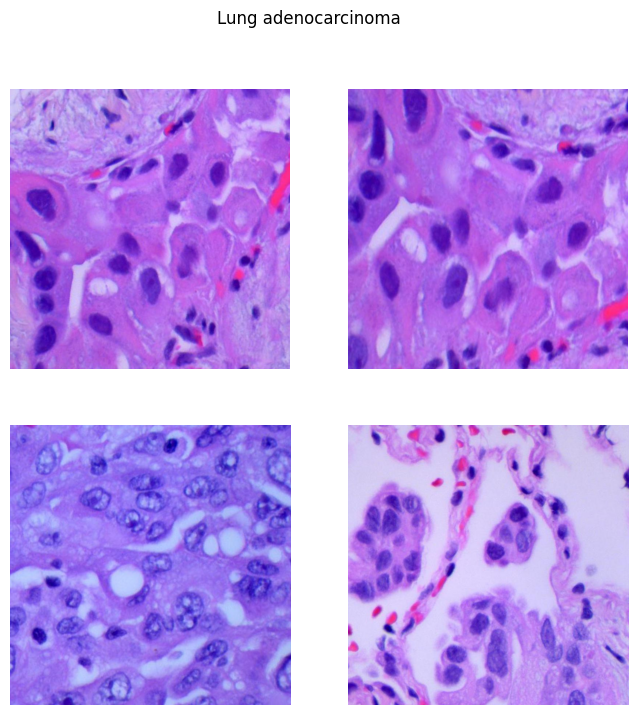

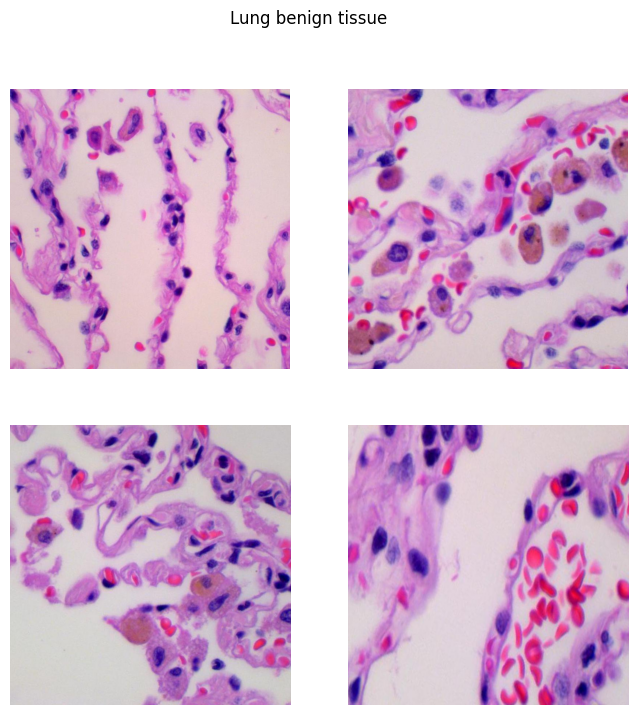

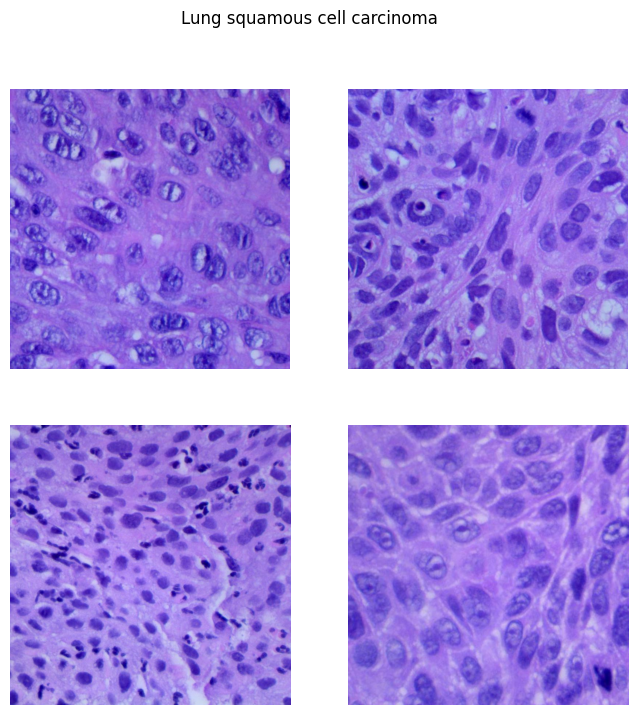

In [4]:
#Se previsualizan las imágenes.
vis_data(lung_aca, lung_n, lung_scc)

In [5]:
# Se crean las variables necesarias para la normalización de las imágenes:

def preprocessing_Inception(image_path, label):

    image, label = general_preprocessing(image_path, label)

    image = tf.keras.applications.inception_v3.preprocess_input(image) 
    #This allows input to have the same format as the images used for training the InceptionV3 net

    return image, label

In [6]:
#Se dividen los datos en los conjuntos de training, validation y testing.
train_dataset, val_dataset, test_dataset = get_dataset(preprocessing_Inception, lung_aca, lung_n, lung_scc)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
2023-12-02 06:27:11.810584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 06:27:11.898006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 06:27:11.898109: I tensorflow/compiler/

In [7]:
#Se carga la red neuronal con la que queramos hacer el Transfer Learning:

In [10]:
InceptionV3 = tf.keras.applications.InceptionV3(input_shape = (350,350,3),
                                               include_top=False,
                                               weights='imagenet')

In [9]:
InceptionV3.trainable = False #Ponemos las capas como NO entrenables
InceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 350, 350, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 174, 174, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 174, 174, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 174, 174, 32)         0         ['batch_normalizati

In [10]:
# Se crean las capas que se quieren añadir al modelo InceptionV3:

In [14]:
output = InceptionV3.layers[-2].output

output = tf.keras.layers.Flatten()(output)

output_layer = tf.keras.layers.Dense(512, activation = 'relu')(output)
output_layer = tf.keras.layers.Dense(256, activation = 'relu')(output_layer)
output_layer = tf.keras.layers.Dense(128, activation = 'relu')(output_layer)
output_layer = tf.keras.layers.Dense(32, activation = 'relu')(output_layer)
output_layer = tf.keras.layers.Dense(16, activation = 'relu')(output_layer)
output_layer = tf.keras.layers.Dense(3, activation = 'softmax')(output_layer)

InceptionV3 = tf.keras.Model(inputs = InceptionV3.inputs, outputs = output_layer)

In [12]:
#En las siguientes celdas se definen los callbacks a usar

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [14]:
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [15]:
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [11]:
checkpoint_filepath = '../ModelCheckpoints/InceptionV3Transfer.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True,
    start_from_epoch=0
)

In [18]:
InceptionV3.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics = ['accuracy'])

In [19]:
history = InceptionV3.fit(train_dataset, epochs=100, batch_size=32, validation_data = val_dataset, callbacks = [learning_rate_scheduler, model_checkpoint_callback, early_stop])

Epoch 1/100


2023-12-01 16:20:26.752963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-12-01 16:20:26.916446: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 16:20:30.180343: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 16:20:30.260571: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efd6c042690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 16:20:30.260589: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-12-01 16:20:30.266529: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-01 16:20:30.337694: I ./tensorflow/compiler/jit/device_comp

375/375 [==============================] - 48s 109ms/step - loss: 0.1697 - accuracy: 0.9365 - val_loss: 0.0846 - val_accuracy: 0.9693 - lr: 1.0000e-04
Epoch 2/100
375/375 [==============================] - 38s 100ms/step - loss: 0.0621 - accuracy: 0.9756 - val_loss: 0.1179 - val_accuracy: 0.9560 - lr: 1.0000e-04
Epoch 3/100
375/375 [==============================] - 38s 100ms/step - loss: 0.0466 - accuracy: 0.9829 - val_loss: 0.1487 - val_accuracy: 0.9487 - lr: 1.0000e-04
Epoch 4/100
375/375 [==============================] - 38s 101ms/step - loss: 0.0318 - accuracy: 0.9889 - val_loss: 0.0484 - val_accuracy: 0.9820 - lr: 1.0000e-04
Epoch 5/100
375/375 [==============================] - 38s 100ms/step - loss: 0.0276 - accuracy: 0.9902 - val_loss: 0.1262 - val_accuracy: 0.9620 - lr: 1.0000e-04
Epoch 6/100
375/375 [==============================] - 38s 100ms/step - loss: 0.0232 - accuracy: 0.9913 - val_loss: 0.0613 - val_accuracy: 0.9767 - lr: 1.0000e-04
Epoch 7/100
375/375 [=============

**Fine tuning**

In [20]:
InceptionV3.load_weights(checkpoint_filepath)

In [21]:
InceptionV3.trainable = True #Se entrena ahora con todos los parámetros

In [22]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate=1e-5) #Se ajusta el learning rate inicial

In [12]:
checkpoint_filepath3 = '../ModelCheckpoints/InceptionV3Fine.h5'
model_checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath3,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [24]:
InceptionV3.compile(loss='categorical_crossentropy', optimizer= optimizer2, metrics = ['accuracy'])

In [25]:
history2 = InceptionV3.fit(train_dataset, epochs=100, batch_size=32, validation_data = val_dataset, callbacks = [learning_rate_scheduler, model_checkpoint_callback3, early_stop])

Epoch 1/100
375/375 [==============================] - 138s 298ms/step - loss: 0.3893 - accuracy: 0.9003 - val_loss: 0.0979 - val_accuracy: 0.9647 - lr: 1.0000e-05
Epoch 2/100
375/375 [==============================] - 112s 299ms/step - loss: 0.0256 - accuracy: 0.9930 - val_loss: 0.0771 - val_accuracy: 0.9740 - lr: 1.0000e-05
Epoch 3/100
375/375 [==============================] - 110s 294ms/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 0.0828 - val_accuracy: 0.9747 - lr: 1.0000e-05
Epoch 4/100
375/375 [==============================] - 112s 299ms/step - loss: 6.9128e-04 - accuracy: 1.0000 - val_loss: 0.0903 - val_accuracy: 0.9747 - lr: 1.0000e-05
Epoch 5/100
375/375 [==============================] - 112s 298ms/step - loss: 3.4088e-04 - accuracy: 1.0000 - val_loss: 0.0962 - val_accuracy: 0.9767 - lr: 1.0000e-05
Epoch 6/100
375/375 [==============================] - 112s 298ms/step - loss: 1.7447e-04 - accuracy: 1.0000 - val_loss: 0.1054 - val_accuracy: 0.9753 - lr: 1.0000e-05
Epoc

In [15]:
InceptionV3.load_weights(checkpoint_filepath3)

In [16]:
y_pred_InceptionV3 = InceptionV3.predict(test_dataset)

2023-12-02 06:28:21.059918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-12-02 06:28:21.225289: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 3/47 [>.............................] - ETA: 2s  

2023-12-02 06:28:24.461105: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


47/47 [==============================] - 11s 135ms/step


In [17]:
#Se guardan las predicciones en un fichero json, por si se quisieran acceder sin cargar el modelo.
with open('predInception_V3', 'w') as file:
    json.dump(y_pred_InceptionV3.tolist(), file)

In [18]:
results_InceptionV3 = get_results(test_dataset, y_pred_InceptionV3)
print(results_InceptionV3)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       500
           1       1.00      1.00      1.00       500
           2       0.95      0.98      0.97       500

   micro avg       0.98      0.98      0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500
 samples avg       0.98      0.98      0.98      1500



In [19]:
#Visualicación para evaluar la explicabilidad del modelo:

In [20]:
#Se generantres números aleatorios para decidir qué imagenes usar para crear los Saliency Maps y Class Activation Maps.
#Al generarse los números aleatorios a partir de la misma semilla, serán los mismos en todas las notebooks.

aca_random = random.randint(1, 5000)
n_random = random.randint(1, 5000)
scc_random = random.randint(1, 5000)

In [21]:
aca_random, n_random, scc_random

(913, 205, 2254)

In [22]:
#Se generan los paths correspondientes a las imágenes seleccionadas aleatoriamente.

aca_path = '../lung_image_sets/lung_aca/lungaca' + str(aca_random) +'.jpeg'
n_path = '../lung_image_sets/lung_n/lungn' + str(n_random) +'.jpeg'
scc_path = '../lung_image_sets/lung_scc/lungscc' + str(scc_random) +'.jpeg'

In [23]:
#Se crea una lista con los paths en cuestión

selected_images = [aca_path, n_path, scc_path]

#### Saliency Map

In [24]:
# Se crea una lista con los paths en los que guardar los Saliency Maps de esta red neuronal para cada una de las imágenes seleccionadas.
saliency_paths = ['./SalMaps/aca_InceptionV3.jpg', './SalMaps/n_InceptionV3.jpg', './SalMaps/scc_InceptionV3.jpg']

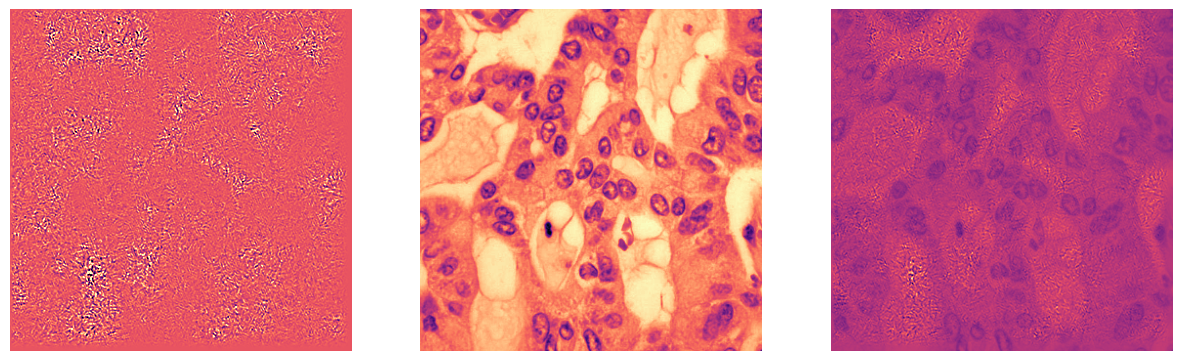

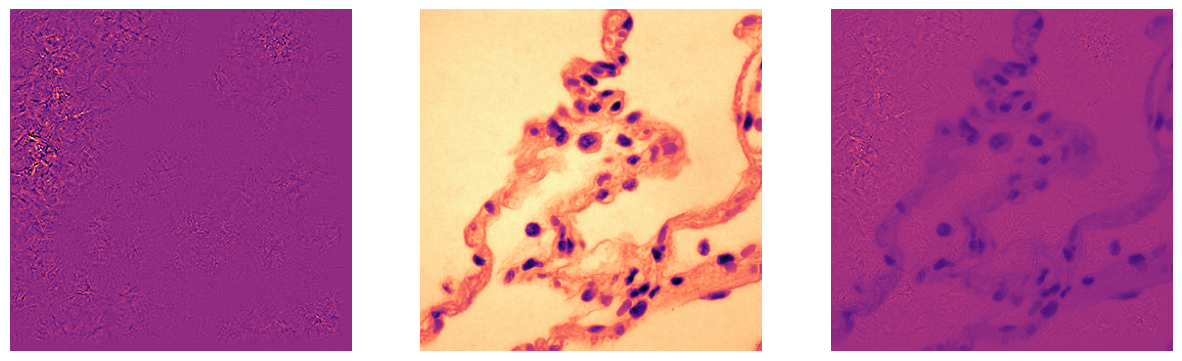

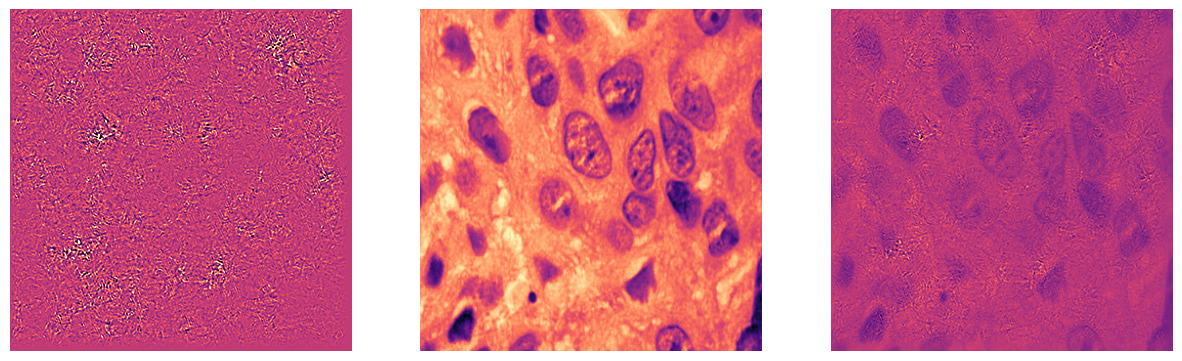

In [25]:
# Se generan los Saliency Maps, se muestran por pantalla y se guardan en los paths correspondientes.
for i in range(len(selected_images)):
    draw_saliency(selected_images[i], InceptionV3, preprocessing_Inception, saliency_paths[i])

#### Class Activation Map

In [26]:
#Se declaran variables necesarias para draw_CAM
img_size = (350, 350)
alpha = 1

In [27]:
# Se crea una lista con los paths en los que guardar los Class Activation Maps de esta red neuronal para cada una de las imágenes seleccionadas.
cam_paths = ['./CamMaps/aca_InceptionV3.jpg', './CamMaps/n_InceptionV3.jpg', './CamMaps/scc_InceptionV3.jpg']

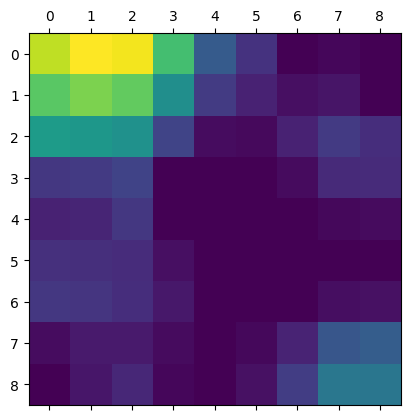

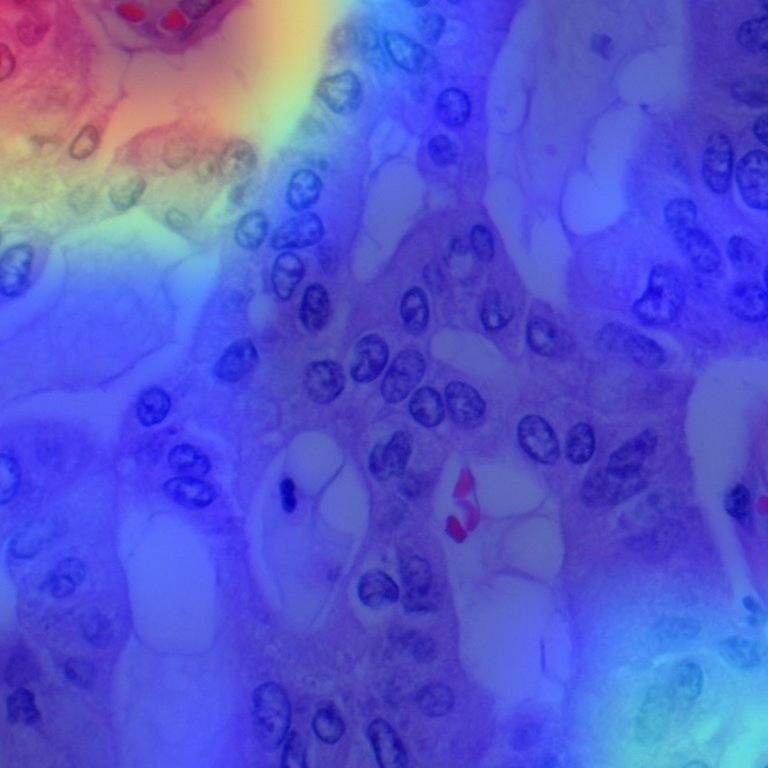

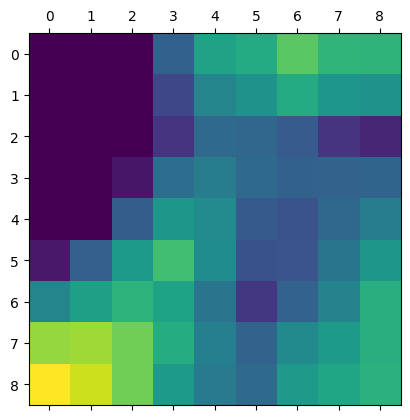

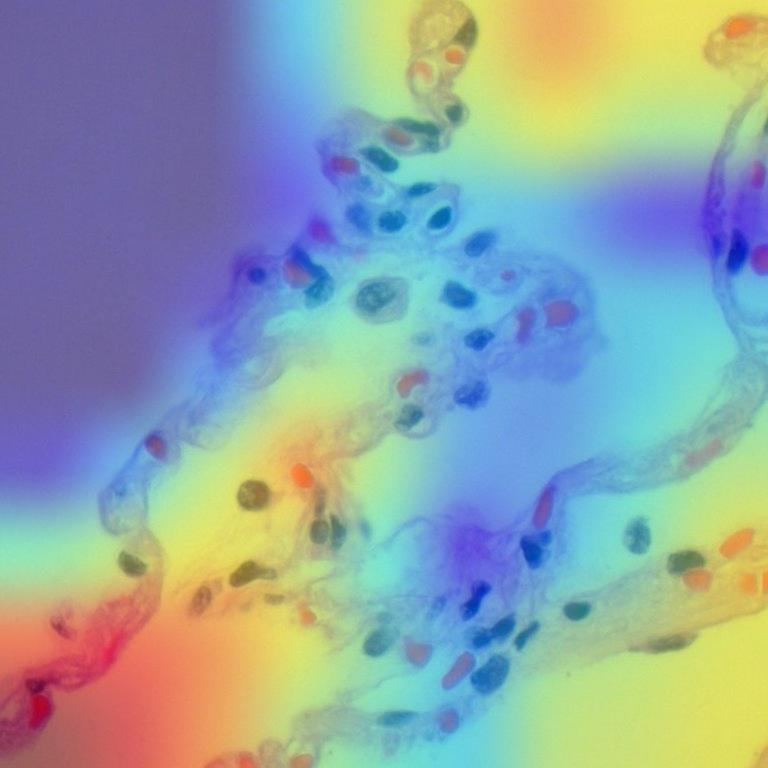

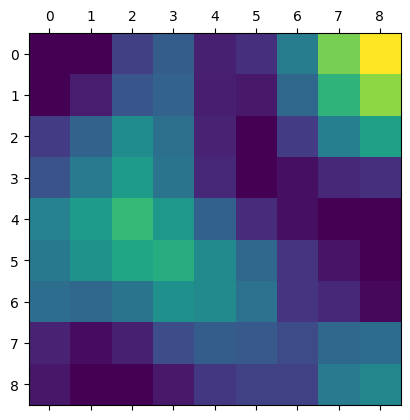

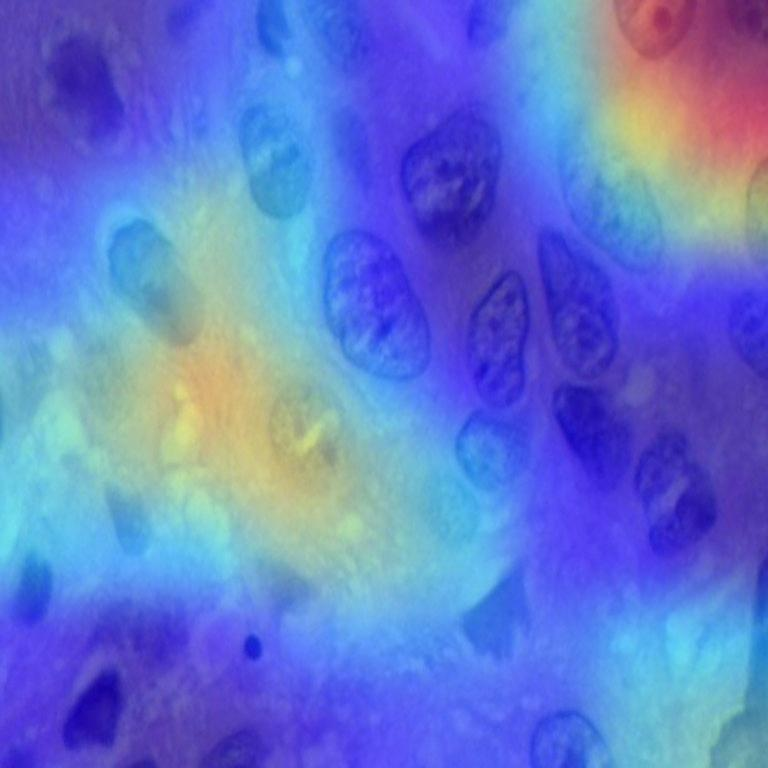

In [28]:
# Se generan los Class Activation Maps, se muestran por pantalla y se guardan en los paths correspondientes.
for i in range(len(selected_images)):
    draw_CAM(selected_images[i], img_size, InceptionV3, 'inception', cam_paths[i], alpha, preprocessing_Inception, pred_index = None)